# Target Feature Category Selection & Preliminary Modeling
Select target feature categories to use for classification

In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import jenkspy
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
from scipy.special import boxcox, inv_boxcox

## IMPORT DATA

In [4]:
# import modeling dataset
df = pd.read_csv('02.data/model_dataset_features_eng.csv')

In [5]:
df.head()

,pca_voting_members,pca_1_financial,pca_2_financial,pca_3_financial,pca_states_pos_1,pca_states_pos_2,reportable_comp,formation_yr,state_median_income,ntee_categories,volunteer_tot_ct,fundraiseservfee_expense_tot_curyr,ceo_comp_review,officer_comp_review,count_of_controls,cluster_label,subsection_501(c)(3),subsection_501(c)(6),subsection_501(c)(5),subsection_501(c)(14),subsection_501(c)(12),subsection_501(c)(7),subsection_501(c)(4),pca_states_neg
0,74.050274,-8.108687e+07,-7.297541e+06,969743.711218,-0.085261,-0.082864,198085.0,1995,56277,"Public, Societal Benefit",0,0,False,False,7,181,False,True,False,False,False,False,False,-0.113183
1,-9.388241,-8.243827e+07,-8.356020e+06,717863.514960,-0.085261,-0.082864,87550.0,1911,56277,"Public, Societal Benefit",100,0,True,True,10,15,False,True,False,False,False,False,False,-0.113183
2,-13.630878,-8.053162e+07,-9.055076e+06,32114.839830,-0.085261,-0.082864,64575.0,1896,56277,"Arts, Culture, and Humanities",50,0,True,True,8,62,True,False,False,False,False,False,False,-0.113183
3,-10.802453,-8.289432e+07,-8.845281e+06,727385.217388,-0.085261,-0.082864,62180.0,1927,56277,"Public, Societal Benefit",4,0,True,True,9,59,False,True,False,False,False,False,False,-0.113183
4,6.168092,-8.150649e+07,-8.088857e+06,680385.672940,-0.085261,-0.082864,130513.0,1952,56277,"Public, Societal Benefit",145,0,True,True,12,180,False,True,False,False,False,False,False,-0.113183


In [6]:
# assign X variables
X = pd.get_dummies(df.drop(['reportable_comp'], axis=1))

In [7]:
X.shape

(120512, 32)

### Check normality of reportable compensation target feature

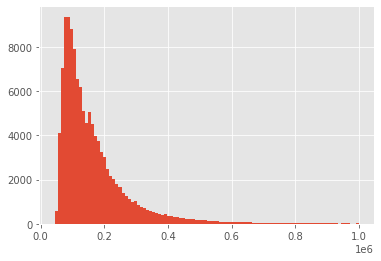

In [119]:
df.reportable_comp.hist(bins=100)

In [120]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
# This function tests the null hypothesis that a sample comes from a normal distribution. 

k2, p = stats.normaltest(df.reportable_comp)
k2, p

(66757.58790544728, 0.0)

With a pvalue at zero this is not a normal distribution.

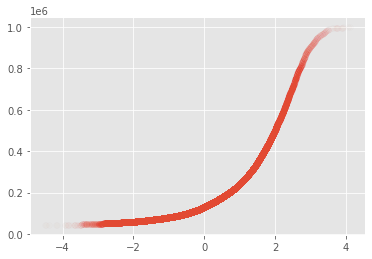

In [316]:
# to visually confirm
# plot target feature against
# normal distribution of random numbers
plt.scatter(pd.Series(np.random.normal(0, 1, features.reportable_comp.shape[0])).sort_values(), 
         features.reportable_comp.sort_values(), alpha=.01);

## ASSIGN LABELS/FEATURES


## pandas qcut - bins set to 10

In [20]:
pd.qcut(df.reportable_comp, q=10, precision=0).cat.codes

0         7
1         2
2         0
3         0
4         4
         ..
128770    1
128771    3
128772    2
128773    3
128774    2
Length: 128775, dtype: int8

In [737]:
pd.qcut(df.reportable_comp, q=10, precision=0).value_counts().sort_index()

(43509.0, 73431.0]        12878
(73431.0, 86415.0]        12878
(86415.0, 100095.0]       12877
(100095.0, 116328.0]      12880
(116328.0, 137410.0]      12875
(137410.0, 162672.0]      12877
(162672.0, 194498.0]      12877
(194498.0, 245320.0]      12878
(245320.0, 358390.0]      12877
(358390.0, 21629920.0]    12878
Name: reportable_comp, dtype: int64

In [21]:
breaks = []

breaks.append(pd.qcut(df.reportable_comp, q=10, precision=0).value_counts().sort_index().index[0].left)

for c in pd.qcut(df.reportable_comp, q=10, precision=0).value_counts().sort_index().index:
    breaks.append(c.right)

In [22]:
len(breaks)

11

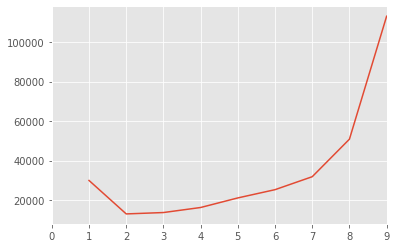

In [23]:
pd.DataFrame(breaks).diff().iloc[:-1,].plot(legend=False)

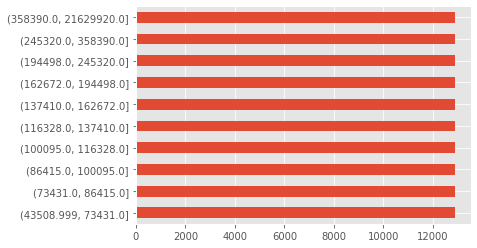

In [24]:
# examine the distribution 
# based on the number of people who fall into each bin
pd.cut(df.reportable_comp,
        bins=breaks,
        include_lowest=True).value_counts().sort_index().plot(kind='barh')

In [25]:
rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, X, pd.qcut(df.reportable_comp, q=10, precision=0).cat.codes, cv=5)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:2

array([0.22201949, 0.21126597, 0.21296836, 0.20403091, 0.23004932])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, pd.qcut(df.reportable_comp, q=10, precision=0).cat.codes, test_size = 0.2)

In [27]:
rfc.fit(X_train, y_train)
X_test['pred'] = rfc.predict(X_test)
X_test['actual'] = y_test

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate 

In [28]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(X_test.actual, X_test.pred) / \
confusion_matrix(X_test.actual, X_test.pred).sum(axis=1, keepdims=True)

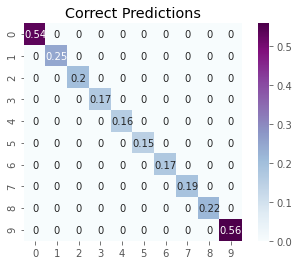

In [29]:
# display only the diagonal values
# representing values the model correctly predicted
sns.heatmap(pd.DataFrame(np.diagflat(np.diagonal(pd.DataFrame(norm_conf_matrix)))),
            cmap='BuPu',
            annot=True,
            square=True,
            );

plt.title('Correct Predictions');

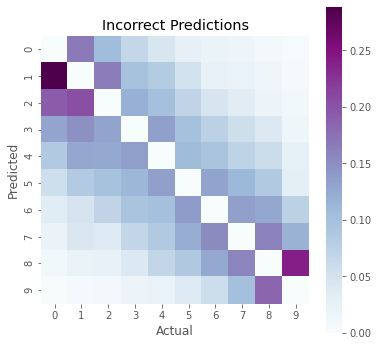

In [30]:
# compare incorrect classification
# using a heatmap
plt.figure(figsize=(6, 6))
np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, 
                 annot=False, 
                 cmap='BuPu')

plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Incorrect Predictions');

Based on an equal distribution of categories, the model seems to struggle most with categories in the middle.

### jenkspy - bins set to 15
jenkspy uses unsupervised learning to find natural breaks in the data

In [31]:
# identify natural breaks using jenks
breaks_15 = jenkspy.jenks_breaks(df.reportable_comp, nb_class=15)

In [119]:
# keep all breaks less than 1M
# while including all breaks greater than 1M together
bins = [b for b in breaks_15 if b < 1000000 or b == max(breaks_15)]

In [120]:
len(bins)

8

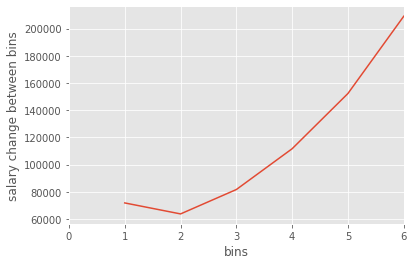

In [61]:
pd.DataFrame(bins).diff().iloc[:-1,].plot(legend=False)
plt.xlabel('bins')
plt.ylabel('salary change between bins');

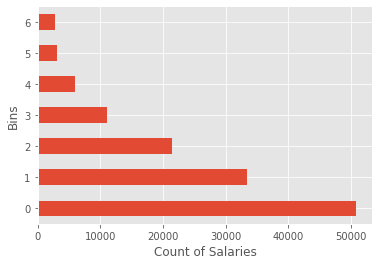

In [121]:
# examine the distribution 
# based on the number of people who fall into each bin
pd.cut(df.reportable_comp,
        bins=bins,
        include_lowest=True).cat.codes.value_counts().sort_index().plot(kind='barh')
plt.xlabel('Count of Salaries')
plt.ylabel('Bins');

The distribution between categories is quite uneven.

In [105]:
y = pd.cut(df.reportable_comp,
        bins=bins,
        include_lowest=True).cat.codes

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [42]:
rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, X, y, cv=5)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:2

array([0.43811631, 0.43422892, 0.44189478, 0.4498505 , 0.4596746 ])

In [107]:
rfc.fit(X_train, y_train)

X_test['pred'] = rfc.predict(X_test)
X_test['actual'] = y_test

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [108]:
X_test.pred.value_counts()

0    11685
1     6140
2     4038
3     1996
4      947
6      500
5      449
Name: pred, dtype: int64

In [109]:
X_test.actual.value_counts()

0    10083
1     6727
2     4360
3     2215
4     1184
5      612
6      574
Name: actual, dtype: int64

In [110]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(X_test.actual, X_test.pred) / \
confusion_matrix(X_test.actual, X_test.pred).sum(axis=1, keepdims=True)

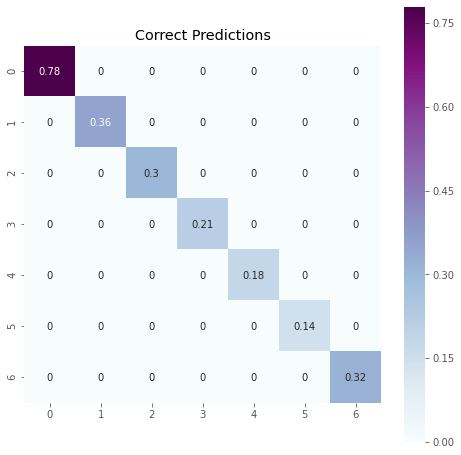

In [111]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(8, 8))

sns.heatmap(pd.DataFrame(np.diagflat(np.diagonal(pd.DataFrame(norm_conf_matrix)))),
            cmap='BuPu',
            annot=True,
            square=True,
            );

plt.title('Correct Predictions');

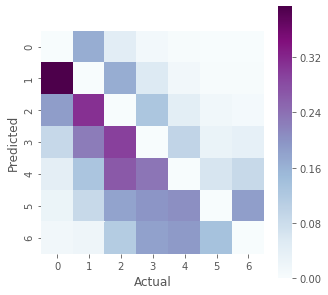

In [47]:
# compare features using a heatmap
plt.figure(figsize=(5, 5))

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, annot=False, 
                 cmap='BuPu')

plt.ylabel('Predicted')
plt.xlabel('Actual');

I'm seeing a pattern here similar to what I saw when I had more bins.  My model is predicting a higher category than the person is actully earning.

### jenkspy - bins set to 30

In [48]:
# identify natural breaks using jenks
breaks_30 = jenkspy.jenks_breaks(df.reportable_comp, nb_class=30)

In [164]:
# keep all breaks less than 1M
# while including all breaks greater than 1M together
bins = [b for b in breaks_30 if b < 2000000 or b == max(breaks_30)]

In [165]:
len(bins)

20

Text(0, 0.5, 'salary change between bins')

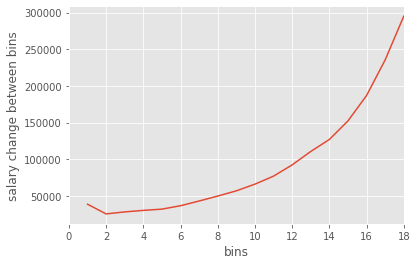

In [58]:
pd.DataFrame(bins).diff().iloc[:-1,].plot(legend=False)
plt.xlabel('bins')
plt.ylabel('salary change between bins');

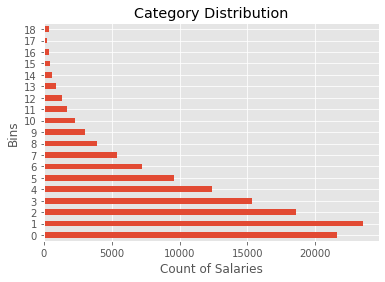

In [135]:
# examine the distribution 
# based on the number of people who fall into each bin
pd.cut(df.reportable_comp,
        bins=bins,
        include_lowest=True).cat.codes.value_counts().sort_index().plot(kind='barh')

plt.xlabel('Count of Salaries')
plt.ylabel('Bins')
plt.title('Category Distribution');

In [114]:
y = pd.cut(df.reportable_comp,
        bins=bins,
        include_lowest=True).cat.codes

In [77]:
rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, X, y, cv=5)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:2

array([0.23262042, 0.22570752, 0.23288682, 0.22252427, 0.23613485])

With an out of box model, performance suffered by adding a higher granularity to the bins.

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [139]:
rfc.fit(X_train, y_train)
X_test['pred'] = rfc.predict(X_test)
X_test['actual'] = y_test

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [140]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(X_test.actual, X_test.pred) / \
confusion_matrix(X_test.actual, X_test.pred).sum(axis=1, keepdims=True)

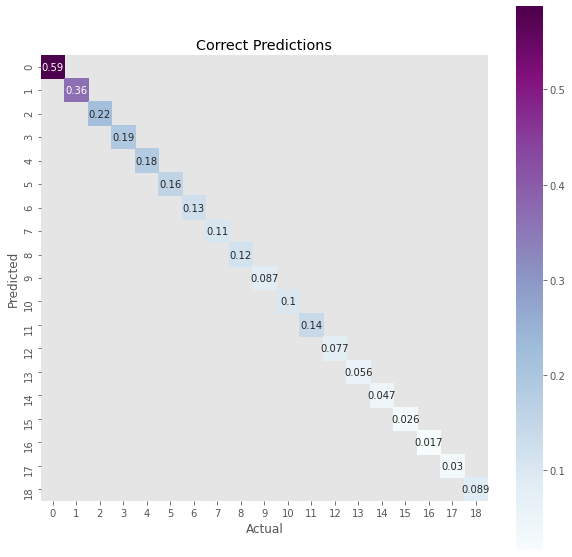

In [146]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(10, 10))

sns.heatmap(pd.DataFrame(np.diagflat(np.diagonal(pd.DataFrame(norm_conf_matrix)))).replace(0, np.nan),
            cmap='BuPu',
            annot=True,
            square=True,
            );
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Correct Predictions');

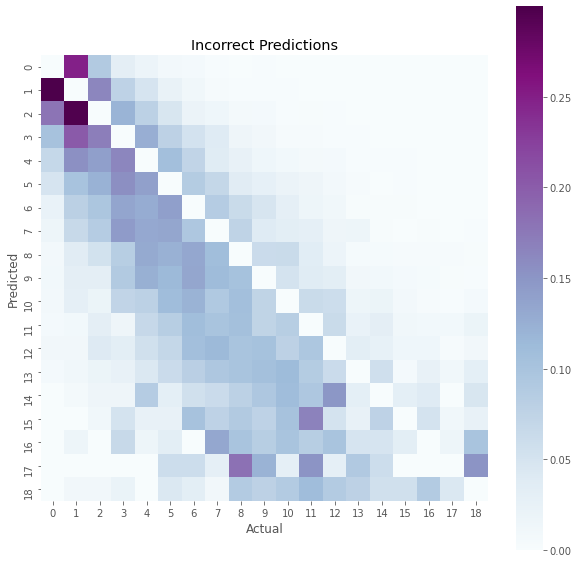

In [147]:
# compare incorrect classification
# using a heatmap
plt.figure(figsize=(10, 10))
np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, 
                 annot=False, 
                 cmap='BuPu')

plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Incorrect Predictions');

The out of box model seems to primarily struggle with predicting a salary to be higher than it otherwise should be, with the exception of the very highest bin.

### jenkspy - bins set to 10 on boxcox transformed data
Because of how many salaries are at the small end of the spectrum, and how the model seems to do best in that area. I wanted to experiment with transforming the target variable to see how it affected model performance.

In [8]:
stats.boxcox(df.reportable_comp)

(array([2.14627385, 2.14282632, 2.14116768, ..., 2.14309769, 2.14354889,
        2.14285305]), -0.4643058544715591)

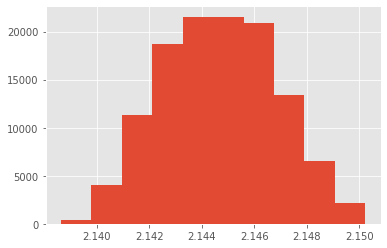

In [9]:
pd.Series(stats.boxcox(df.reportable_comp)[0]).hist()

The salary range looks normally distributed now.

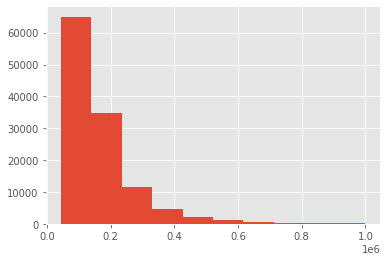

In [8]:
df.reportable_comp.hist()

In [9]:
# identify natural breaks using jenks
breaks_box_cox = jenkspy.jenks_breaks(stats.boxcox(df.reportable_comp)[0], nb_class=10)

In [10]:
breaks_box_cox

[2.1386355121084377,
 2.1411665955129946,
 2.142212402489361,
 2.143120093616062,
 2.143988356138678,
 2.1448516734343532,
 2.1456905016707593,
 2.1465205501129403,
 2.1474319499132366,
 2.148524402613094,
 2.150225288885593]

In [7]:
len(breaks_box_cox)

11

In [11]:
# get the inverse of box-cox 
# to see the levels of the classification
list(inv_boxcox(breaks_box_cox, stats.boxcox(df.reportable_comp)[1]))

[43509.99999999986,
 64563.00000000147,
 77826.00000000362,
 92843.00000000172,
 111539.99999999483,
 136149.9999999895,
 168499.99999999363,
 212925.00000002194,
 284589.00000002084,
 428257.0000000055,
 999510.9999998697]

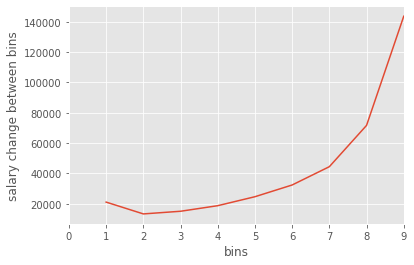

In [9]:
pd.DataFrame(list(inv_boxcox(breaks_box_cox, stats.boxcox(df.reportable_comp)[1]))).diff().iloc[:-1,].plot(legend=False)
plt.xlabel('bins')
plt.ylabel('salary change between bins');

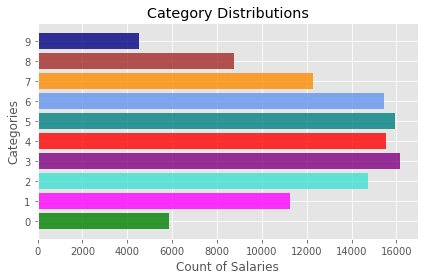

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))
from itertools import cycle

colors = ['navy', 
        'brown', 
        'darkorange', 
        'cornflowerblue', 
        'teal',
        'red',
       'purple',
       'turquoise',
       'magenta',
       'green']

for i, cat, color in zip([x for x in range(0, 10)],
                      pd.cut(pd.Series(stats.boxcox(df.reportable_comp)[0]),
        bins=breaks_box_cox,
        include_lowest=True).cat.codes.value_counts().sort_index().values, 
                      list(reversed(colors))):
    plt.barh(width=cat, y=i, color=color, alpha=.8)

plt.xlabel('Count of Salaries')
plt.yticks([x for x in range(0, 10)])

plt.ylabel('Categories')
plt.title('Category Distributions')
plt.tight_layout()

plt.savefig('03.visualizations/category_breaks_dist.png');

Using boxcox, the distribution between categories is a bit more even, neither side has a long tail.

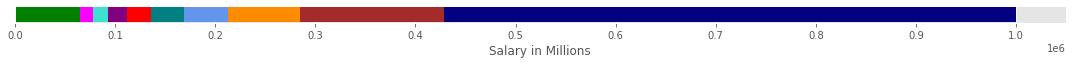

In [76]:
# visualize the jump in salary
# between bin levels
fig, ax = plt.subplots(figsize=(15, 1))
from itertools import cycle

colors = ['navy', 
        'brown', 
        'darkorange', 
        'cornflowerblue', 
        'teal',
        'red',
       'purple',
       'turquoise',
       'magenta',
       'green']

for cat, color in zip(pd.Series(inv_boxcox(breaks_box_cox, stats.boxcox(df.reportable_comp)[1]))[1:] \
    .reset_index(drop=True).sort_index(ascending=False), colors):
    plt.barh(width=cat, y=0, color=color)

ax.axes.get_yaxis().set_visible(False)
plt.xlabel('Salary in Millions')
plt.xticks([x for x in range(0, 1100000, 100000)])
# plt.title('Salary Break Levels')
plt.tight_layout()
plt.savefig('03.visualizations/salary_category_schedule.png');

In [19]:
[x for x in range(0, 10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

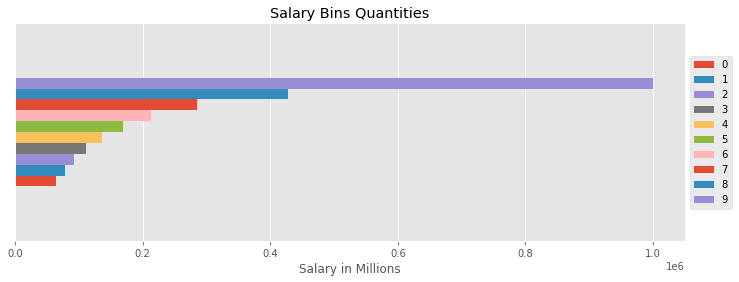

In [67]:
ax = pd.DataFrame(pd.Series(inv_boxcox(breaks_box_cox, stats.boxcox(df.reportable_comp)[1]))[1:].reset_index(drop=True)) \
.T.plot.barh(
figsize=(12, 4))

ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))
ax.axes.get_yaxis().set_visible(False)
plt.xlabel('Salary in Millions')
plt.title('Salary Bins Quantities')
# plt.savefig('03.visualizations/salary_category_schedule.png');

### Preliminary modeling to see if these bins improve classification results

In [47]:
y = pd.cut(pd.Series(stats.boxcox(df.reportable_comp)[0]),
        bins=breaks_box_cox,
        include_lowest=True).cat.codes

In [48]:
X.head()

,pca_voting_members,pca_1_financial,pca_2_financial,pca_3_financial,pca_states_pos_1,pca_states_pos_2,formation_yr,state_median_income,volunteer_tot_ct,fundraiseservfee_expense_tot_curyr,ceo_comp_review,officer_comp_review,count_of_controls,cluster_label,subsection_501(c)(3),subsection_501(c)(6),subsection_501(c)(5),subsection_501(c)(14),subsection_501(c)(12),subsection_501(c)(7),subsection_501(c)(4),pca_states_neg,"ntee_categories_Arts, Culture, and Humanities",ntee_categories_Education,ntee_categories_Environment and Animals,ntee_categories_Health,ntee_categories_Human Services,"ntee_categories_International, Foreign Affairs",ntee_categories_Mutual/Membership Benefit,"ntee_categories_Public, Societal Benefit",ntee_categories_Religion Related,"ntee_categories_Unknown, Unclassified"
0,74.050274,-8.108687e+07,-7.297541e+06,969743.711218,-0.085261,-0.082864,1995,56277,0,0,False,False,7,181,False,True,False,False,False,False,False,-0.113183,0,0,0,0,0,0,0,1,0,0
1,-9.388241,-8.243827e+07,-8.356020e+06,717863.514960,-0.085261,-0.082864,1911,56277,100,0,True,True,10,15,False,True,False,False,False,False,False,-0.113183,0,0,0,0,0,0,0,1,0,0
2,-13.630878,-8.053162e+07,-9.055076e+06,32114.839830,-0.085261,-0.082864,1896,56277,50,0,True,True,8,62,True,False,False,False,False,False,False,-0.113183,1,0,0,0,0,0,0,0,0,0
3,-10.802453,-8.289432e+07,-8.845281e+06,727385.217388,-0.085261,-0.082864,1927,56277,4,0,True,True,9,59,False,True,False,False,False,False,False,-0.113183,0,0,0,0,0,0,0,1,0,0
4,6.168092,-8.150649e+07,-8.088857e+06,680385.672940,-0.085261,-0.082864,1952,56277,145,0,True,True,12,180,False,True,False,False,False,False,False,-0.113183,0,0,0,0,0,0,0,1,0,0


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [50]:
rfc = ensemble.RandomForestClassifier()

In [51]:
rfc.fit(X_train, y_train)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
# predict categores
pred = rfc.predict(X_test)

In [53]:
rfc.score(X_test, y_test)

0.24001161681118532

In [54]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(y_test, pred) / \
confusion_matrix(y_test, pred).sum(axis=1, keepdims=True)

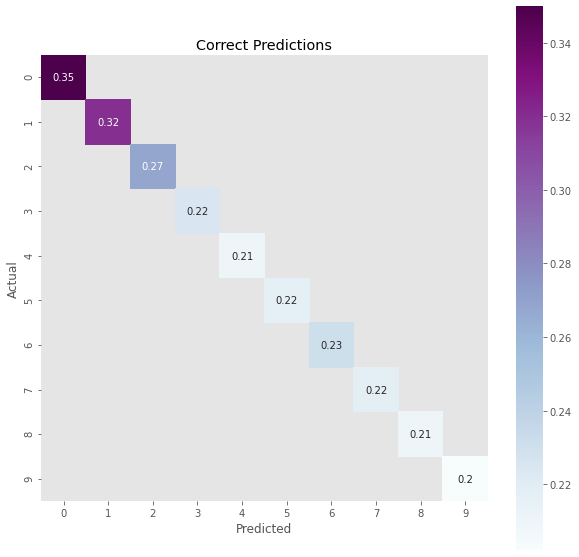

In [55]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(10, 10))

sns.heatmap(np.where(np.diagflat(np.diagonal(norm_conf_matrix))
            ==0, np.nan, np.diagflat(np.diagonal(norm_conf_matrix))),
            cmap='BuPu',
            annot=True,
            square=True,
            );
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Correct Predictions');

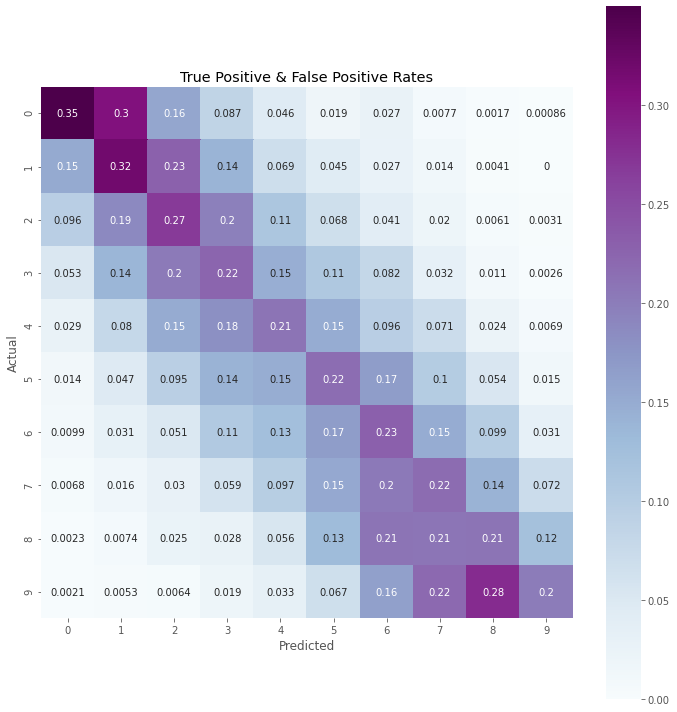

In [56]:
# compare correct and incorrect predictions
plt.figure(figsize=(10, 10))
# np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, annot=True, 
                 cmap='BuPu')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('True Positive & False Positive Rates')
plt.tight_layout()
plt.savefig('03.visualizations/heat_map_rfc.png');

In [57]:
f_importances = pd.Series(rfc.feature_importances_, 
          X_train.columns).sort_values(ascending=False)

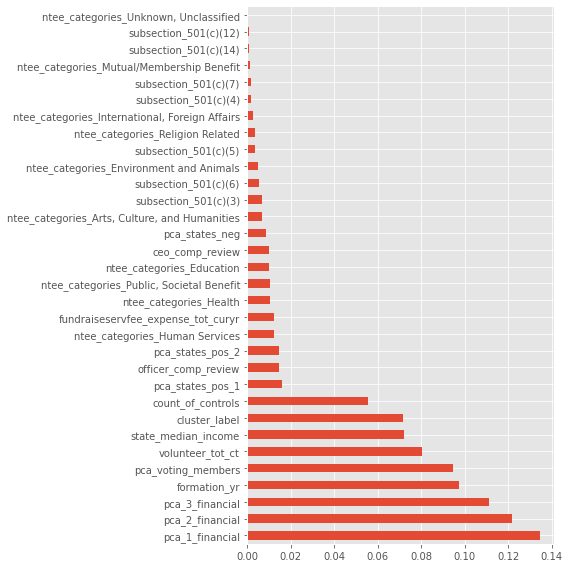

In [58]:
f_importances.plot(kind='barh', figsize=(8, 8))
plt.tight_layout()
plt.savefig('03.visualizations/rfc_feature_importance.png');

## EXPORT TARGET FEATURE LABEL BINS FOR FURTHER MODELING
Although a higher number of bins hurts my model performance, I feel comfortable that a model with a higher number of bins will allow my model to be more valuable to an end user.  This will also allow me to have more visibility into how best to parameter tune the model.  As a result, I will use 20 bins that I created using jenkspy as my final labels for modeling. 

In [12]:
y.to_csv('02.data/target_categories_box_cox.csv', index=False, header=False)

In [14]:
# export median salary levels for each bin
pd.concat([df.reportable_comp,
           y], axis=1).groupby(0) \
    .median().to_csv('02.data/category_median_salary.csv', index=False, header=True)